**This notebook is an exercise in the [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/binary-classification).**

---


# Introduction #

In this exercise, you'll build a model to predict hotel cancellations with a binary classifier.

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex6 import *

First, load the *Hotel Cancellations* dataset.

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('../input/dl-course-data/hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

# 1) Define Model #

The model we'll use this time will have both batch normalization and dropout layers. To ease reading we've broken the diagram into blocks, but you can define it layer by layer as usual.

Define a model with an architecture given by this diagram:

<figure style="padding: 1em;">
<img src="https://i.imgur.com/V04o59Z.png" width="400" alt="Diagram of network architecture: BatchNorm, Dense, BatchNorm, Dropout, Dense, BatchNorm, Dropout, Dense.">
<figcaption style="textalign: center; font-style: italic"><center>Diagram of a binary classifier.</center></figcaption>
</figure>


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

# YOUR CODE HERE: define the model given in the diagram
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


# Check your answer
q_1.check()

2022-12-10 12:39:45.829134: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

# 2) Add Optimizer, Loss, and Metric #

Now compile the model with the Adam optimizer and binary versions of the cross-entropy loss and accuracy metric.

In [4]:
# YOUR CODE HERE
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# Check your answer
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [5]:
# Lines below will give you a hint or solution code
#q_2.hint()
#q_2.solution()

Finally, run this cell to train the model and view the learning curves. It may run for around 60 to 70 epochs, which could take a minute or two.

2022-12-10 12:39:46.137228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
175/175 [==============================] - 5s 19ms/step - loss: 0.4825 - binary_accuracy: 0.7736 - val_loss: 0.4348 - val_binary_accuracy: 0.7956
Epoch 2/200
175/175 [==============================] - 3s 15ms/step - loss: 0.4252 - binary_accuracy: 0.7997 - val_loss: 0.4019 - val_binary_accuracy: 0.8116
Epoch 3/200
175/175 [==============================] - 3s 14ms/step - loss: 0.4110 - binary_accuracy: 0.8062 - val_loss: 0.3955 - val_binary_accuracy: 0.8174
Epoch 4/200
175/175 [==============================] - 3s 14ms/step - loss: 0.4040 - binary_accuracy: 0.8097 - val_loss: 0.3896 - val_binary_accuracy: 0.8204
Epoch 5/200
175/175 [==============================] - 3s 15ms/step - loss: 0.3974 - binary_accuracy: 0.8132 - val_loss: 0.3879 - val_binary_accuracy: 0.8195
Epoch 6/200
175/175 [==============================] - 3s 15ms/step - loss: 0.3944 - binary_accuracy: 0.8151 - val_loss: 0.3826 - val_binary_accuracy: 0.8240
Epoch 7/200
175/175 [==============================]

<AxesSubplot:title={'center':'Accuracy'}>

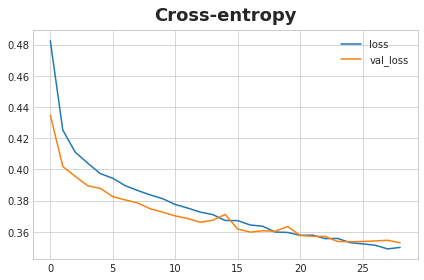

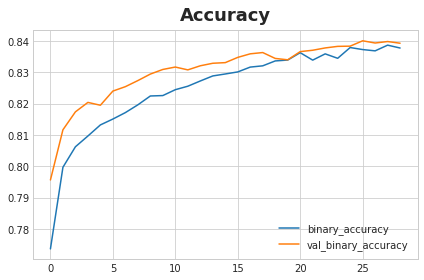

In [6]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

# 3) Train and Evaluate #


What do you think about the learning curves? Does it look like the model underfit or overfit? Was the cross-entropy loss a good stand-in for accuracy?

In [7]:
# View the solution (Run this cell to receive credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Though we can see the training loss continuing to fall, the early stopping callback prevented any overfitting. Moreover, the accuracy rose at the same rate as the cross-entropy fell, so it appears that minimizing cross-entropy was a good stand-in. All in all, it looks like this training was a success!

# Conclusion #

Congratulations! You've completed Kaggle's *Introduction to Deep Learning* course!

With your new skills you're ready to take on more advanced applications like computer vision and sentiment classification. What would you like to do next?

Why not try one of our *Getting Started* competitions?

- Classify images with TPUs in [**Petals to the Metal**](https://www.kaggle.com/c/tpu-getting-started)
- Create art with GANs in [**I'm Something of a Painter Myself**](https://www.kaggle.com/c/gan-getting-started)
- Classify Tweets in [**Real or Not? NLP with Disaster Tweets**](https://www.kaggle.com/c/nlp-getting-started)
- Detect contradiction and entailment in [**Contradictory, My Dear Watson**](https://www.kaggle.com/c/contradictory-my-dear-watson)

Until next time, Kagglers!

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-deep-learning/discussion) to chat with other learners.*